# Combinación de ambos modelos

En este notebook vamos a recrear el proceso completo con los dos modelos que hemos entrenado, desde cargar una imagen inicial hasta la obtención del archivo MIDI final.

## Cargamos los modelos

In [1]:
from models.extender_midi.model import MelodIAModel, Utilities
from models.foto_a_midi.main import FotoAMIDI
import joblib

# Cargamos los modelos
MODEL_PARAMS_PATH = "pretrained_models/modelo_params_midi.h5"
SCALER_PATH = "models/foto_a_midi/scaler.pkl"
MODEL_MIDI_EXTENSION_PATH = "pretrained_models/modelo_extension_midi.keras"

modelo_params = FotoAMIDI(modelo_ruta=MODEL_PARAMS_PATH, usar_clip=True)
modelo_params.load_modelo()
modelo_params.set_scaler(joblib.load(SCALER_PATH))

modelo_extender_midi = MelodIAModel.load_model(MODEL_MIDI_EXTENSION_PATH)

2025-05-18 20:09:36.906498: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 20:09:36.922534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747591776.939678  151577 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747591776.944610  151577 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747591776.959190  151577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Modelo cargado desde: pretrained_models/modelo_extension_midi.keras


## Modelo 1: Foto a MIDI

In [2]:
import os
from PIL import Image
from Scripts.python.midi_generator_acordes import ParamsAMIDI

# Cargamos la imagen
IMAGE_PATH = "./models/foto_a_midi/datos/test/snow.jpg"
im = Image.open(IMAGE_PATH)

Metemos la imagen en el modelo y predecimos sus parametros

In [ ]:
params = modelo_params.predict(im)

I0000 00:00:1747591789.669743  151726 service.cc:152] XLA service 0x7f3d40004720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747591789.669805  151726 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-05-18 20:09:49.684573: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747591789.702945  151726 cuda_dnn.cc:529] Loaded cuDNN version 90501


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


I0000 00:00:1747591789.883417  151726 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Podemos ver los parámetros generados

In [4]:
params

{'tonalidad_value': np.float64(0.32952771043277596),
 'tempo': np.float64(97.0),
 'duracion_media': np.float64(1.5296958777117486),
 'sigma': np.float64(0.5604123005417309),
 'velocidad_media': np.float64(0.8507442270569159),
 'densidad_media': np.float64(0.6509456750583507),
 'caracter_melodico': np.float64(0.7139184855786882),
 'usar_acordes': np.float64(1.0),
 'proporcion_acordes': np.float64(0.4605018856999854),
 'rango_octavas': np.float64(1.0)}

In [ ]:
from models.foto_a_midi.modelo import clip_parametros

# Convertimos los parámetros a los tipos correctos
keys = params.keys()
values = clip_parametros(list(params.values()))
params2 = dict(zip(keys, values))
print(params2)

{'tonalidad_value': np.float64(0.32952771043277596), 'tempo': 97, 'duracion_media': np.float64(1.5296958777117486), 'sigma': np.float64(0.5604123005417309), 'velocidad_media': np.float64(0.8507442270569159), 'densidad_media': np.float64(0.6509456750583507), 'caracter_melodico': np.float64(0.7139184855786882), 'usar_acordes': 1, 'proporcion_acordes': np.float64(0.4605018856999854), 'rango_octavas': 1}


Generamos un archivo MIDI a partir de los parámetros devueltos por el modelo

In [ ]:
MIDI_PATH = "prueba_nieve.mid"

# Generamos el midi a partir de los parámetros obtenidos
midi_basico = ParamsAMIDI(**params2)
midi_basico.generar_midi(MIDI_PATH)

# Si el midi tiene menos de 25 notas, lo concatenamos
import pretty_midi

pm = pretty_midi.PrettyMIDI(MIDI_PATH)

Archivo MIDI generado: prueba_nieve3.mid


Como el segundo modelo utiliiza secuencias de 25 notas, comprobamos si el MIDI generado tiene al menos 25 notas. Si no, añadimos más notas.

In [8]:
num_notas = len(pm.instruments[0].notes)

if (num_notas < 25):
    n = 25 / num_notas + 1
    aux = pm
    for i in range(0, n):
        aux = Utilities.concatenate_pretty_midi(pm, aux)
    pm = aux

## Modelo 2: Extensión del archivo MIDI generado

Seleccionamos las últimas 25 notas del MIDI generado anteriormente. Esta secuencia de notas será el input de este segundo modelo.

In [10]:
import pretty_midi

df = Utilities.midi_path_to_df(MIDI_PATH)
notes = Utilities.midi_to_numpy(pm)
notes_sequence = notes[num_notas-25:num_notas] # últimas 25 notas
notes = MelodIAModel.normalize(notes_sequence) 

Generamos las nuevas notas con el modelo. Haremos una predicción por cada nota que queramos generar (en este caso 40). Para la predicción de la siguiente nota se añade a la secuencia de 25 notas la última nota predicha como última nota de la secuencia.

In [11]:
# Se pueden cambiar el número de predicciones y la temperatura
generated_notes = MelodIAModel.predict_sequence(modelo_extender_midi, notes, num_predictions=40, temperature=0.8)

generated_notes = MelodIAModel.desnormalize(generated_notes)
generado = Utilities.notes_to_midi(generated_notes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

Unimos el fragmento MIDI original con el generado

In [12]:
combined = Utilities.concatenate_pretty_midi(pm, generado)

Lo visualizamos

/home/carmenfdez/MUS/melodIA/models/extender_midi/model.py:310: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


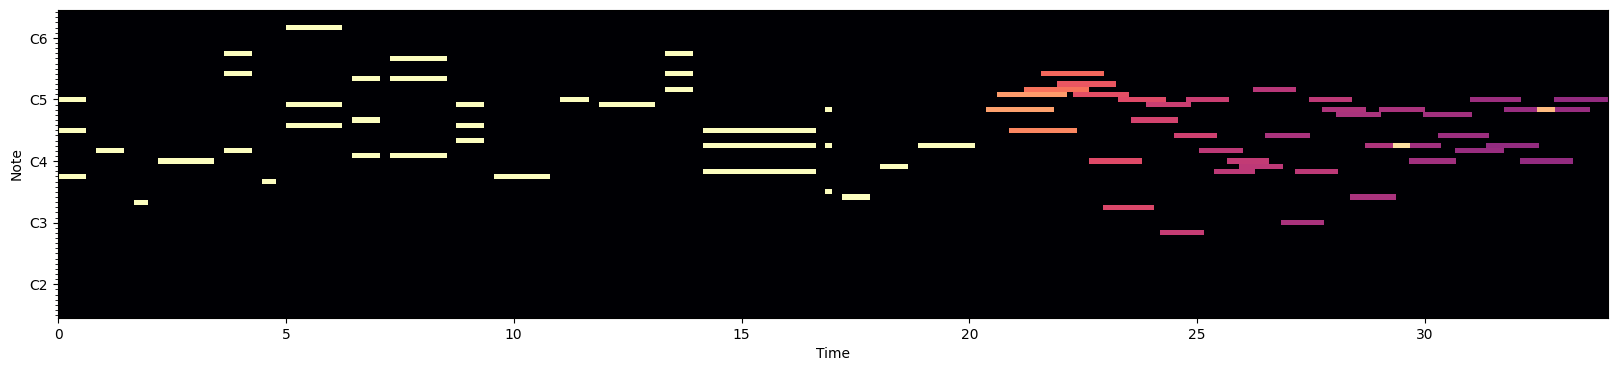

In [13]:
Utilities.plot_piano_roll(combined, 30, 90)

Visualizamos la imagen

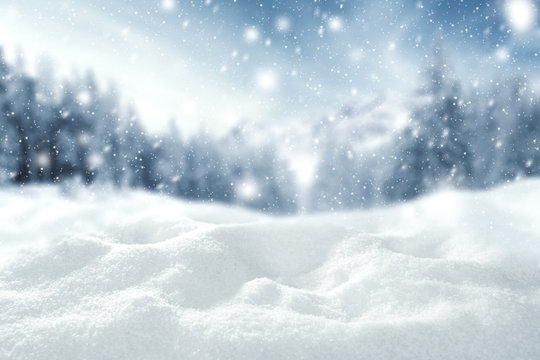

In [15]:
im.show()

Escuchamos el resultado

In [14]:
Utilities.display_audio(combined, seconds=60)

Por último lo guardamos

In [ ]:
combined.write("midi_nieve.mid")

## Bucle para procesar varias imágenes seguidas

Este notebook es una demostración, pero se podrían procesas varias imágenes seguidas con un bucle. Por ejemplo, todas las imágenes que estan dentro de un determinado directorio.

In [ ]:
TEST_FOLDER = "models/foto_a_midi/datos/test"

for filename in os.listdir(TEST_FOLDER):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(TEST_FOLDER, filename)
        imagen = Image.open(image_path)
        params = modelo_params.predict(im)
        keys = params.keys()
        values = clip_parametros(list(params.values()))
        params2 = dict(zip(keys, values))

        MIDI_PATH = f"{filename}.mid"
        # Generamos el midi a partir de los parámetros obtenidos
        midi_basico = ParamsAMIDI(**params2)
        midi_basico.generar_midi(MIDI_PATH)
        # Si el midi tiene menos de 25 notas, lo concatenamos
        pm = pretty_midi.PrettyMIDI(MIDI_PATH)
        
        num_notas = len(pm.instruments[0].notes)

        if (num_notas < 25):
            n = 25 / num_notas + 1
            aux = pm
            for i in range(0, n):
                aux = Utilities.concatenate_pretty_midi(pm, aux)
            pm = aux

        df = Utilities.midi_path_to_df(MIDI_PATH)
        notes = Utilities.midi_to_numpy(pm)
        notes_sequence = notes[num_notas-25:num_notas] # últimas 25 notas
        notes = MelodIAModel.normalize(notes_sequence) 
        
        generated_notes = MelodIAModel.predict_sequence(modelo_extender_midi, notes, num_predictions=40, temperature=0.8)

        generated_notes = MelodIAModel.desnormalize(generated_notes)
        generado = Utilities.notes_to_midi(generated_notes)

        combined = Utilities.concatenate_pretty_midi(pm, generado)
        combined.write(f"{filename}_final.mid")